In [1]:
# Simulation
from scipy import constants
import numpy as np
from scipy.integrate import solve_ivp

# Optimization
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm

# Physical Constants
hbar = constants.hbar
kB = constants.Boltzmann
muB = constants.value('proton mag. mom.') / constants.value('proton mag. mom. to Bohr magneton ratio')
Da = constants.value('atomic mass constant')

# Strontium 88 parameters
m = 88 * Da
Gamma = 2 * np.pi * 32 * 10**6 # linewidth of 32MHz (angular frequency)
k = (2 * np.pi) / (0.461 * 10**-6)
IO = 42.5 # Saturation intensity, mW/cm^2
gJ = 1.

# Free parameters
s0l = 2
s0r = 2
Delta2D = -1.5
Delta3D = -2.5
DeltaPush = -0.9
Bgrad2D = 130. * 10**2
Bgrad3D = 50. * 10**2
wtransverse2D = 4. * 10**-3
wlongitude2D = 10. * 10**-3
s03DMOTX1 = 1.
s03DMOTX2 = 1.
s03DMOTY1 = 1.
s03DMOTY2 = 1.
s03DMOTZ1 = 1.
s03DMOTZ2 = 1.
w3D = 0.01
s0push = 0.01
wPush = 3. * 10**-3

# Fixed parameters
MOT3dXoffset = 0.
MOT3dYoffset = -0.003
MOT3dZoffset = 0.43
offset = np.array([MOT3dXoffset, MOT3dYoffset, MOT3dZoffset])
g = 9.8
pushbeamMaxZ = 0.1

# Capture condition (at what position / speed do we count atoms as captured?)
targetZoneSize = 2 * 10**-3
maxSpeed = 10

In [2]:
# MOT Functions
r22 = lambda s0, delta: (0.5 * s0) / (1 + s0 + 4 * delta**2)

def ax2DMOT(delta, v, x, y, z):
    return np.exp(-2 * y**2 / wtransverse2D**2) \
            * np.exp(-2 * z**2 / wlongitude2D**2) * (hbar * k * Gamma / m) \
            * (r22(s0l, delta - ((k * v) / Gamma) - (x * Bgrad2D * muB * gJ / (10**4 * hbar * Gamma))) \
             - r22(s0r, delta + ((k * v) / Gamma) + (x * Bgrad2D * muB * gJ / (10**4 * hbar * Gamma))))

def ax3DMOT(delta, v, x, y, z):
    return np.exp(-2 * y**2 / w3D**2) \
            * np.exp(-2 * z**2 / w3D**2) * (hbar * k * Gamma / m) \
            * (r22(s03DMOTX1, delta - ((k * v) / Gamma) - (x * Bgrad3D * muB * gJ / (10**4 * hbar * Gamma))) \
             - r22(s03DMOTX2, delta + ((k * v) / Gamma) + (x * Bgrad3D * muB * gJ / (10**4 * hbar * Gamma))))

def ay2DMOT(delta, v, x, y, z):
    return np.exp(-2 * x**2 / wtransverse2D**2) \
            * np.exp(-2 * z**2 / wlongitude2D**2) * (hbar * k * Gamma / m) \
            * (r22(s0l, delta - ((k * v) / Gamma) - (y * Bgrad2D * muB * gJ / (10**4 * hbar * Gamma))) \
             - r22(s0r, delta + ((k * v) / Gamma) + (y * Bgrad2D * muB * gJ / (10**4 * hbar * Gamma))))

def ay3DMOT(delta, v, x, y, z):
    return np.exp(-2 * x**2 / w3D**2) \
            * np.exp(-2 * z**2 / w3D**2) * (hbar * k * Gamma / m) \
            * (r22(s03DMOTY1, delta - ((k * v) / Gamma) - (y * Bgrad3D * muB * gJ / (10**4 * hbar * Gamma))) \
             - r22(s03DMOTY2, delta + ((k * v) / Gamma) + (y * Bgrad3D * muB * gJ / (10**4 * hbar * Gamma))))

az2DMOT = lambda delta, v, x, y, z: 0

def azPush(delta, v, x, y, z):
    if z < pushbeamMaxZ:
        return np.exp(-2 * x**2 / wPush**2) * np.exp(-2 * y**2 / wPush**2) * (hbar * k * Gamma / m) \
                * r22(s0push, delta - ((k * v) / Gamma))
    else:
        return 0

def az3DMOT(delta, v, x, y, z):
    return np.exp(-2 * x**2 / w3D**2) * np.exp(-2 * y**2 / w3D**2) * np.exp(-2 * z**2 / w3D**2) * (hbar * k * Gamma / m) \
            * (r22(s03DMOTZ1, delta - ((k * v) / Gamma) - (z * Bgrad3D * muB * gJ / (10**4 * hbar * Gamma))) \
             - r22(s03DMOTZ2, delta + ((k * v) / Gamma) + (z * Bgrad3D * muB * gJ / (10**4 * hbar * Gamma))))

def axMOT(v, x, y, z):
    return ax2DMOT(Delta2D, v, x, y, z) \
            + ax3DMOT(Delta3D, v, x - MOT3dXoffset, y - MOT3dYoffset, z - MOT3dZoffset)

def ayMOT(v, x, y, z):
    return ay2DMOT(Delta2D, v, x, y, z) \
            + ay3DMOT(Delta3D, v, x - MOT3dXoffset, y - MOT3dYoffset, z - MOT3dZoffset) - g

def azMOT(v, x, y, z):
    return az2DMOT(Delta2D, v, x, y, z) \
            + az3DMOT(Delta3D, v, x - MOT3dXoffset, y - MOT3dYoffset, z - MOT3dZoffset) \
            + azPush(DeltaPush, v, x, y, z)


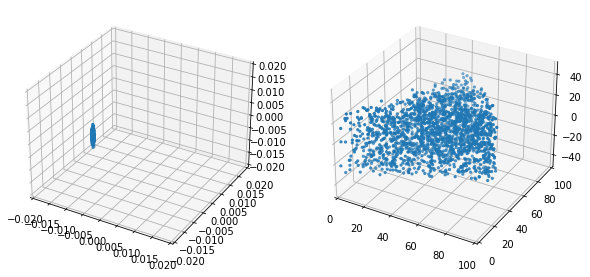

Number of atoms: 1933


In [13]:
# Atom Initialization

# Jet Loading Parameters
jetParams = {
    'T': 600,
    'Sigmav': np.sqrt(kB * 600 / m),
    'Mux': -9 * 10**-3,
    'Muy': -9 * 10**-3,
    'Muz': 0., # 10**-3?
    'Sigmax': 0.1 * 10**-3,
    'Sigmay': 0.1 * 10**-3,
    'Sigmaz': 1.25 * 10**-3,
    'fullacceptanceAngle': 40.
}

runs = 2000000
tFinal = 0.05
preFilterMaxAxialSpeed = 30.
preFilterMaxTranverseSpeed = 100.

# Jet Initialization
initialPositions = np.vstack((
    np.random.normal(jetParams['Mux'], jetParams['Sigmax'], runs),
    np.random.normal(jetParams['Muy'], jetParams['Sigmay'], runs),
    np.random.normal(jetParams['Muz'], jetParams['Sigmaz'], runs)
)).T

initialVelocities = np.vstack((
    np.random.normal(0, jetParams['Sigmav'], runs),
    np.random.normal(0, jetParams['Sigmav'], runs),
    np.random.normal(0, jetParams['Sigmav'], runs)
)).T

initPositionsFiltered = []
initVelocitiesFiltered = []

for idx in range(runs):
    angle_cutoff = jetParams['fullacceptanceAngle'] 
    if initialVelocities[idx, 1] > 0 \
    and (np.pi / 180) * (45 - angle_cutoff / 2) <= np.arctan(initialVelocities[idx, 1] / initialVelocities[idx, 0]) \
    and np.arctan(initialVelocities[idx, 1] / initialVelocities[idx, 0]) <= (np.pi / 180) * (45 + angle_cutoff / 2) \
    and np.abs(initialVelocities[idx, 2]) <= preFilterMaxAxialSpeed \
    and np.sqrt(initialVelocities[idx, 0]**2 + initialVelocities[idx, 1]**2) <= preFilterMaxTranverseSpeed:
        initPositionsFiltered.append(initialPositions[idx, :])
        initVelocitiesFiltered.append(initialVelocities[idx, :])

initPositionsFiltered = np.asarray(initPositionsFiltered)
initVelocitiesFiltered =  np.asarray(initVelocitiesFiltered)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax.scatter(initPositionsFiltered[:, 0], initPositionsFiltered[:, 1], initPositionsFiltered[:, 2], zdir='z', s=5)
ax2.scatter(initVelocitiesFiltered[:, 0], initVelocitiesFiltered[:, 1], initVelocitiesFiltered[:, 2], zdir='z', s=5)
ax.set_xlim(-0.02, 0.02)
ax.set_ylim(-0.02, 0.02)
ax.set_zlim(-0.02, 0.02)

ax2.set_xlim(0, 100)
ax2.set_ylim(0, 100)
ax2.set_zlim(-50, 50)

plt.show()

assert (len(initPositionsFiltered) == len(initVelocitiesFiltered))
num_atoms = len(initPositionsFiltered) 
print ("Number of atoms: {}".format(num_atoms))


In [14]:
# ODE Solver

def ivp(t, vec):
    x, y, z, vx, vy, vz = tuple(vec)
    return [vx, vy, vz, axMOT(vx, x, y, z), ayMOT(vy, x, y, z), azMOT(vz, x, y, z)]

init_conditions = np.hstack((initPositionsFiltered, initVelocitiesFiltered))

outputs = []
for idx in tqdm(range(num_atoms)):
    output = solve_ivp(ivp, (0, 0.05), init_conditions[idx, :], vectorized=True)
    outputs.append(output)

In [16]:
opt = np.array([output.y[:, -1] for output in outputs])
print (opt.shape)

finalPositions = opt[:, 0:3]
finalVelocities = opt[:, 3:6]

captured = []

# Capture Analysis
for idx in range(num_atoms):
    if np.linalg.norm(finalPositions[idx] - offset) <= targetZoneSize:
        if np.linalg.norm(finalVelocities[idx]) <= maxSpeed:
            captured.append(idx)
print (len(captured))

(1933, 6)
33


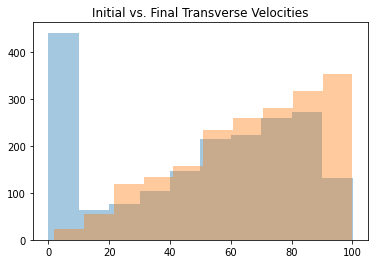

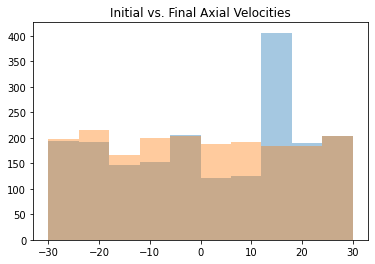

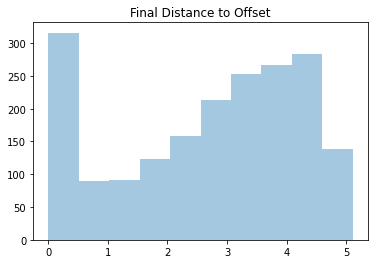

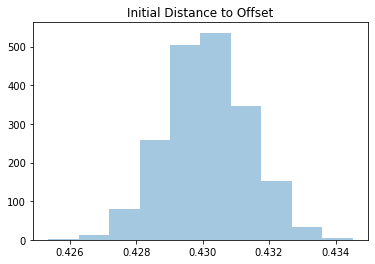

In [17]:
finalTransverseVelo = np.sqrt(finalVelocities[:, 0]**2 + finalVelocities[:, 1]**2)
finalAxialVelo = finalVelocities[:, 2]

initialTransverseVelo = np.sqrt(initVelocitiesFiltered[:, 0]**2 + initVelocitiesFiltered[:, 1]**2)
initialAxialVelo = initVelocitiesFiltered[:, 2]

plt.hist(finalTransverseVelo, alpha=0.4)
plt.hist(initialTransverseVelo, alpha=0.4)
plt.title("Initial vs. Final Transverse Velocities")
plt.show()

plt.hist(finalAxialVelo, alpha=0.4)
plt.hist(initialAxialVelo, alpha=0.4)
plt.title("Initial vs. Final Axial Velocities")
plt.show()

finalDistance = np.linalg.norm(finalPositions - offset, axis=1)
initialDistance = np.linalg.norm(initPositionsFiltered - offset, axis=1)

plt.hist(finalDistance, alpha=0.4)
plt.title("Final Distance to Offset")
plt.show()

plt.hist(initialDistance, alpha=0.4)
plt.title("Initial Distance to Offset")
plt.show()